In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 7.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, adjusted_rand_score
from sklearn.ensemble import RandomForestClassifier
import shap


# **Load the Data_combined Data**

In [ ]:
df = pd.read_excel('/content/sample_data/Data_Combined.xlsx')

In [ ]:
df.describe()

,Unnamed: 0,Patient_Number,Glucose_Level,Cholestrol,Temp,Weight,BMI,Height,Waist_circumference,HB,...,Fam_hx_CVD,High_Chol,Kidney_problems,Liver_problems,Gender_y,Participant_Number,Age_of_Participant_b,sample_id,APOE2,APOE4
count,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,...,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000
mean,128.500000,457.484496,4.546512,5.383721,36.120155,81.007752,30.480620,1.984496,98.282946,14.015504,...,1.639535,1.379845,1.015504,1.007752,1.744186,457.484496,46.802326,457.484496,0.263566,0.422481
std,74.622383,202.422051,1.781817,0.964368,0.337507,19.202989,7.356514,0.123786,15.026610,2.422285,...,0.576710,0.685523,0.175747,0.124515,0.437166,202.422051,10.681618,202.422051,0.467119,0.588309
min,0.000000,1.000000,2.000000,4.000000,35.000000,43.000000,16.000000,1.000000,62.000000,7.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,29.000000,1.000000,0.000000,0.000000
25%,64.250000,333.500000,4.000000,5.000000,36.000000,67.000000,25.000000,2.000000,87.250000,12.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,333.500000,37.000000,333.500000,0.000000,0.000000
50%,128.500000,512.500000,4.000000,5.000000,36.000000,79.000000,29.000000,2.000000,97.000000,14.000000,...,2.000000,1.000000,1.000000,1.000000,2.000000,512.500000,46.000000,512.500000,0.000000,0.000000
75%,192.750000,629.500000,5.000000,6.000000,36.000000,92.000000,35.000000,2.000000,109.000000,16.000000,...,2.000000,2.000000,1.000000,1.000000,2.000000,629.500000,55.000000,629.500000,0.750000,1.000000
max,257.000000,721.000000,17.000000,8.000000,37.000000,178.000000,59.000000,2.000000,149.000000,21.000000,...,3.000000,3.000000,3.000000,3.000000,2.000000,721.000000,78.000000,721.000000,2.000000,2.000000


In [ ]:
df.shape

(258, 61)

**Filter data for Pfizer and J&J vaccinations only**

In [ ]:
df = df[df['Vaccine_Type'].isin(['Pfizer', 'J&J'])]

# **Feature Engineering and removal of redundant features**

In [ ]:
df.columns

Index(['Unnamed: 0', 'Patient_Number', 'Glucose_Level', 'Cholestrol', 'Temp',
       'Weight', 'BMI', 'Height', 'Waist_circumference', 'HB', 'Gender_x',
       'Age', 'HLE', 'Smoking', 'Physical_activity', 'PA/week', 'PA level',
       'HPT', 'Low/high_Blood_sugar', 'Fam_hx_CVD', 'High_Chol',
       'Kidney_problems', 'Liver_problems', 'Gender_y', 'Participant_Number',
       'Age_of_Participant_b', 'Vaccine_Type', 'Vaccination_Status',
       'Number_of_Doses', 'Boosting_Status', 'Side_Effects',
       'Symptoms_and_Treatment', 'Hospitalization', 'Co-Morbidities',
       'BP_Average', 'Weight_Category', 'Occupation', 'Marital_status',
       'Hazardous exposure', 'Alcohol', 'Symp_Cold', 'Symp_Cough',
       'Symp_Sore_throat', 'Symp_Headache', 'breathlessness', 'taste_Smell',
       'Close_to_Someonewith_Covid', 'COVID-19_comorbidities', 'Symp_Cold_i',
       'Symp_Cough_i', 'Symp_Sore_throat_i', 'Symp_Headache_i',
       'breathlessness_i', 'taste_Smell_i', 'Close_to_Someonewith_Covi

In [ ]:
# Assuming 'Vaccinated_SARS-CoV-2' is the column for vaccination status
df['VaccinationStatus'] = df['Vaccination_Status'].map({'complete': 1, 'incomplete': 0})
df['BoostingStatus'] = df['Boosting_Status'].map({'boosted': 1, 'Not Boosted': 0})
df['Breakthrough_Infection'] = df['break_through'].map({'Y': 1, 'N': 0})

# Remove redundant features
columns_to_drop = ['Vaccination_Status', 'break_through', 'Patient_Number', 'Participant_Number']
df = df.drop(columns=columns_to_drop)



# **Data cleaning and preprocessing (Handle missing data)**

In [ ]:
df = df.dropna()

In [ ]:

from sklearn.preprocessing import StandardScaler, LabelEncoder

# Encoding categorical data
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    # Convert the column to string type to ensure uniformity
    df[column] = df[column].astype(str)  # Convert the column to string type

    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Handle missing data if any
df.fillna(df.mean(), inplace=True)

# **Elbow method to find optimal number of clusters**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

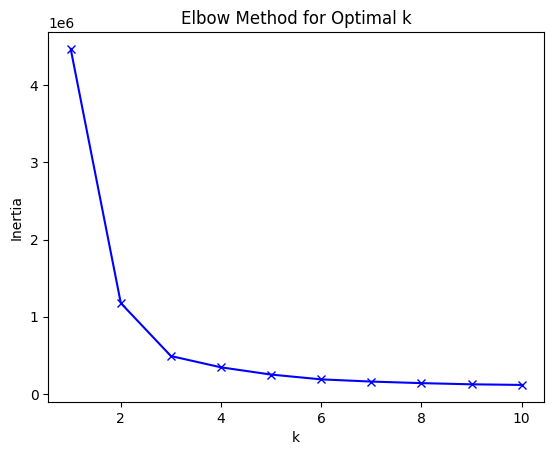

In [ ]:
inertias = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)
    inertias.append(kmeans.inertia_)

plt.plot(k_range, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


In [ ]:
optimal_k = 3


# **Train K-means model and evaluate**

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(df)

silhouette_avg = silhouette_score(df, cluster_labels)
calinski_harabasz = calinski_harabasz_score(df, cluster_labels)
wcss = kmeans.inertia_


print(f"Silhouette Score: {silhouette_avg}")
print(f"Calinski-Harabasz Score: {calinski_harabasz}")
print(f"Within-Cluster Sum of Squares: {wcss}")



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.5673993172762334
Calinski-Harabasz Score: 426.7825235817744
Within-Cluster Sum of Squares: 489682.0234927236


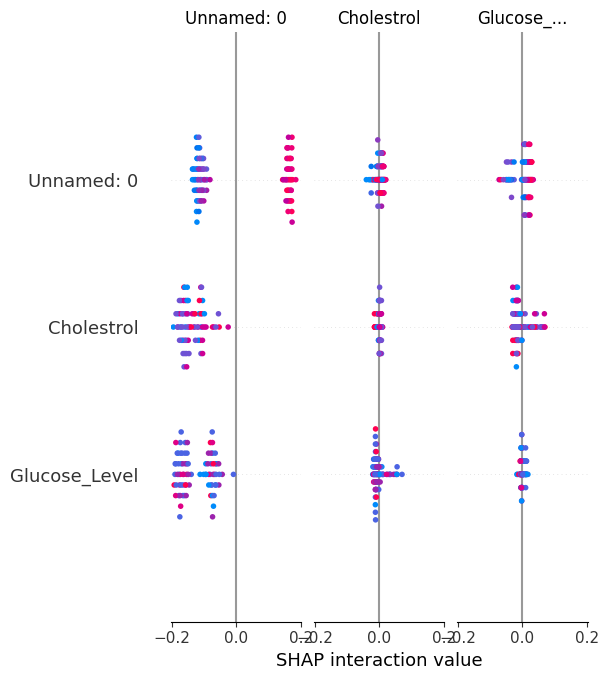

In [ ]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(df, cluster_labels)

explainer = shap.TreeExplainer(rf_classifier)
shap_values = explainer.shap_values(df)

shap.summary_plot(shap_values, df, plot_type="bar")


# **Get Feature importance**

In [ ]:
feature_importance = pd.DataFrame({'feature': df.columns, 'importance': rf_classifier.feature_importances_})
top_features = feature_importance.sort_values('importance', ascending=False).head(10)


In [ ]:
df.columns

Index(['Unnamed: 0', 'Glucose_Level', 'Cholestrol', 'Temp', 'Weight', 'BMI',
       'Height', 'Waist_circumference', 'HB', 'Gender_x', 'Age', 'HLE',
       'Smoking', 'Physical_activity', 'PA/week', 'PA level', 'HPT',
       'Low/high_Blood_sugar', 'Fam_hx_CVD', 'High_Chol', 'Kidney_problems',
       'Liver_problems', 'Gender_y', 'Age_of_Participant_b', 'Vaccine_Type',
       'Number_of_Doses', 'Boosting_Status', 'Side_Effects',
       'Symptoms_and_Treatment', 'Hospitalization', 'Co-Morbidities',
       'BP_Average', 'Weight_Category', 'Occupation', 'Marital_status',
       'Hazardous exposure', 'Alcohol', 'Symp_Cold', 'Symp_Cough',
       'Symp_Sore_throat', 'Symp_Headache', 'breathlessness', 'taste_Smell',
       'Close_to_Someonewith_Covid', 'COVID-19_comorbidities', 'Symp_Cold_i',
       'Symp_Cough_i', 'Symp_Sore_throat_i', 'Symp_Headache_i',
       'breathlessness_i', 'taste_Smell_i', 'Close_to_Someonewith_Covid_i',
       'sample_id', 'APOE2', 'APOE4', 'raw_APOE2', 'raw_APOE4',

# **Distribution of vaccines and breakthrough infections in clusters**

In [ ]:
df['Cluster'] = cluster_labels
vaccine_distribution = df.groupby(['Cluster', 'Vaccine_Type']).size().unstack(fill_value=0)
bt_infection_distribution = df.groupby(['Cluster', 'Breakthrough_Infection']).size().unstack(fill_value=0)
bt_infection_percentage = df.groupby(['Cluster', 'Vaccine_Type'])['Breakthrough_Infection'].mean().unstack(fill_value=0) * 100


In [ ]:
print("Vaccine Distribution:")
print(vaccine_distribution)
print("\nBreakthrough Infection Distribution:")
print(bt_infection_distribution)
print("\nBreakthrough Infection Percentage:")
print(bt_infection_percentage)


Vaccine Distribution:
Vaccine_Type   0   1
Cluster             
0              6  39
1              6  20
2             15  22

Breakthrough Infection Distribution:
Breakthrough_Infection   0   1
Cluster                       
0                       28  17
1                       21   5
2                       29   8

Breakthrough Infection Percentage:
Vaccine_Type          0          1
Cluster                           
0             50.000000  35.897436
1             33.333333  15.000000
2             13.333333  27.272727


# **Visualizations**

**Mean values of important numerical features**

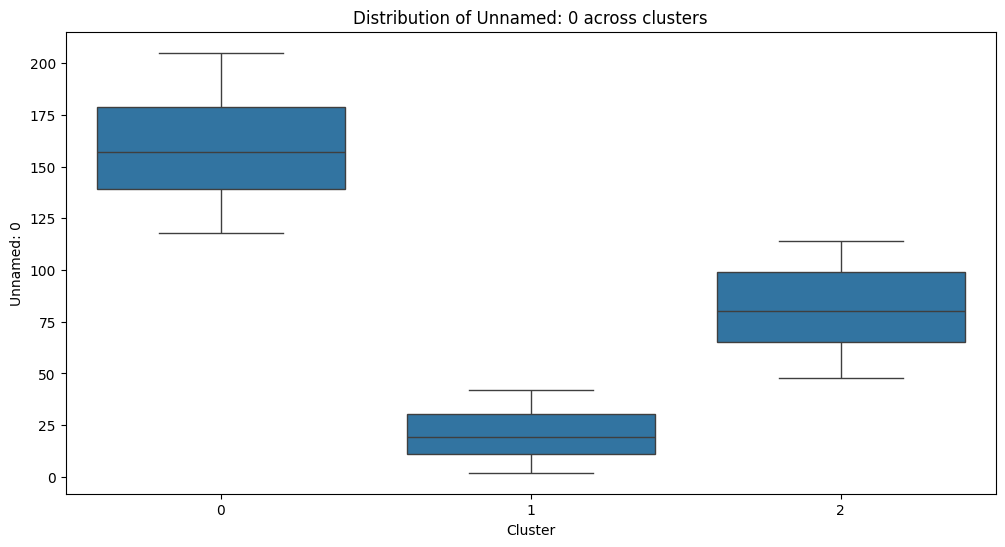

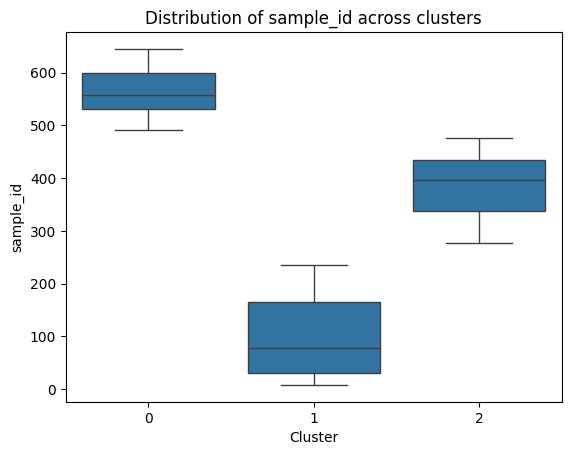

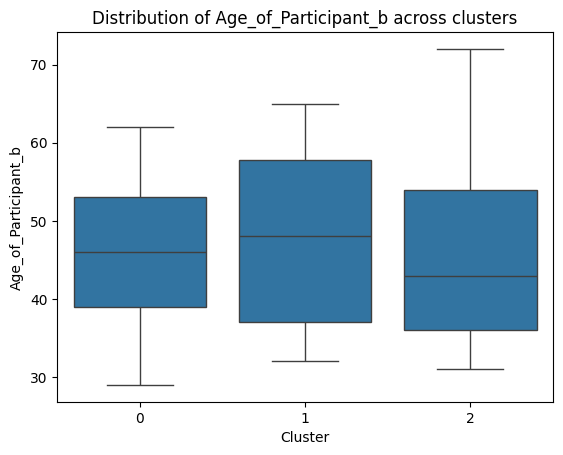

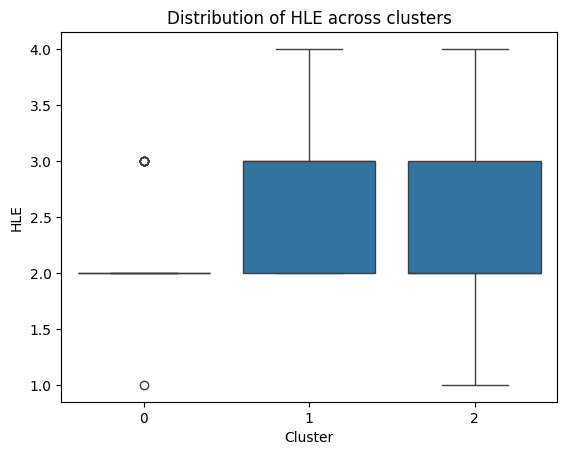

In [ ]:
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(12, 6))
for feature in top_features['feature'][:5]:  # Top 5 numerical features
   if feature in numerical_columns:
        sns.boxplot(x='Cluster', y=feature, data=df)
        plt.title(f'Distribution of {feature} across clusters')
        plt.show()



**Categorical features**

In [ ]:
df['Cluster'] = kmeans.labels_

df['Cluster'] = df['Cluster'].astype(str)

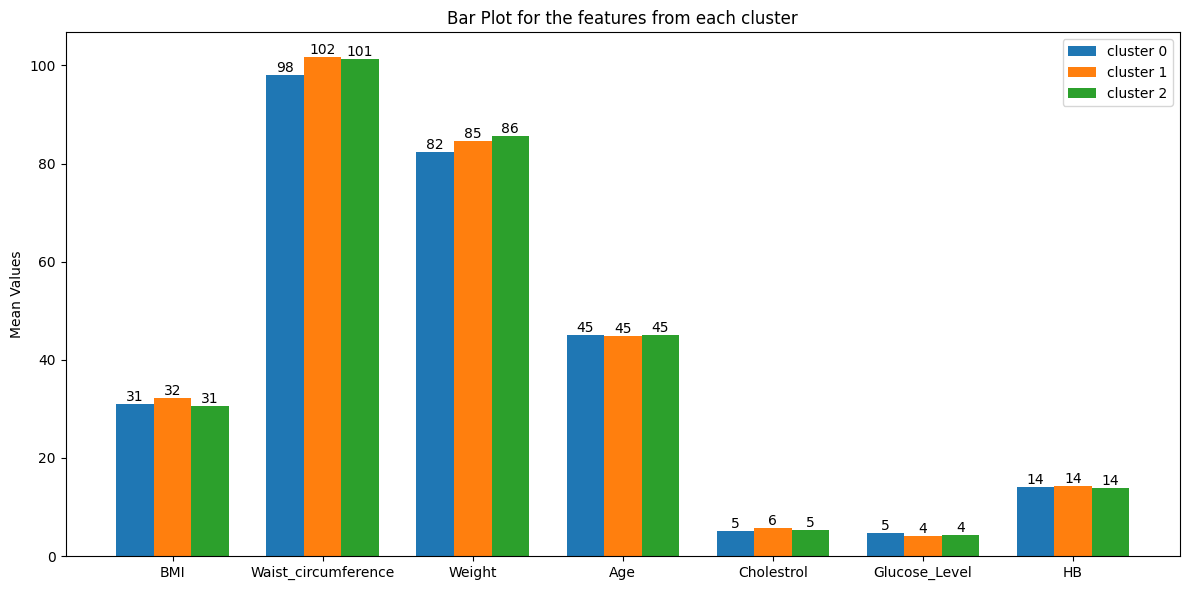

In [ ]:
features_to_plot = ['BMI', 'Waist_circumference', 'Weight', 'Age', 'Cholestrol', 'Glucose_Level', 'HB']
cluster_means = df.groupby('Cluster')[features_to_plot].mean()
fig, ax = plt.subplots(figsize=(12, 6))
width = 0.25
x = np.arange(len(features_to_plot))
for i, cluster in enumerate(cluster_means.index):
    ax.bar(x + i*width, cluster_means.loc[cluster], width, label=f'cluster {cluster}')

ax.set_ylabel('Mean Values')
ax.set_title('Bar Plot for the features from each cluster')
ax.set_xticks(x + width)
ax.set_xticklabels(features_to_plot)
ax.legend()
for i, cluster in enumerate(cluster_means.index):
    for j, value in enumerate(cluster_means.loc[cluster]):
        ax.text(j + i*width, value, f'{value:.0f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()


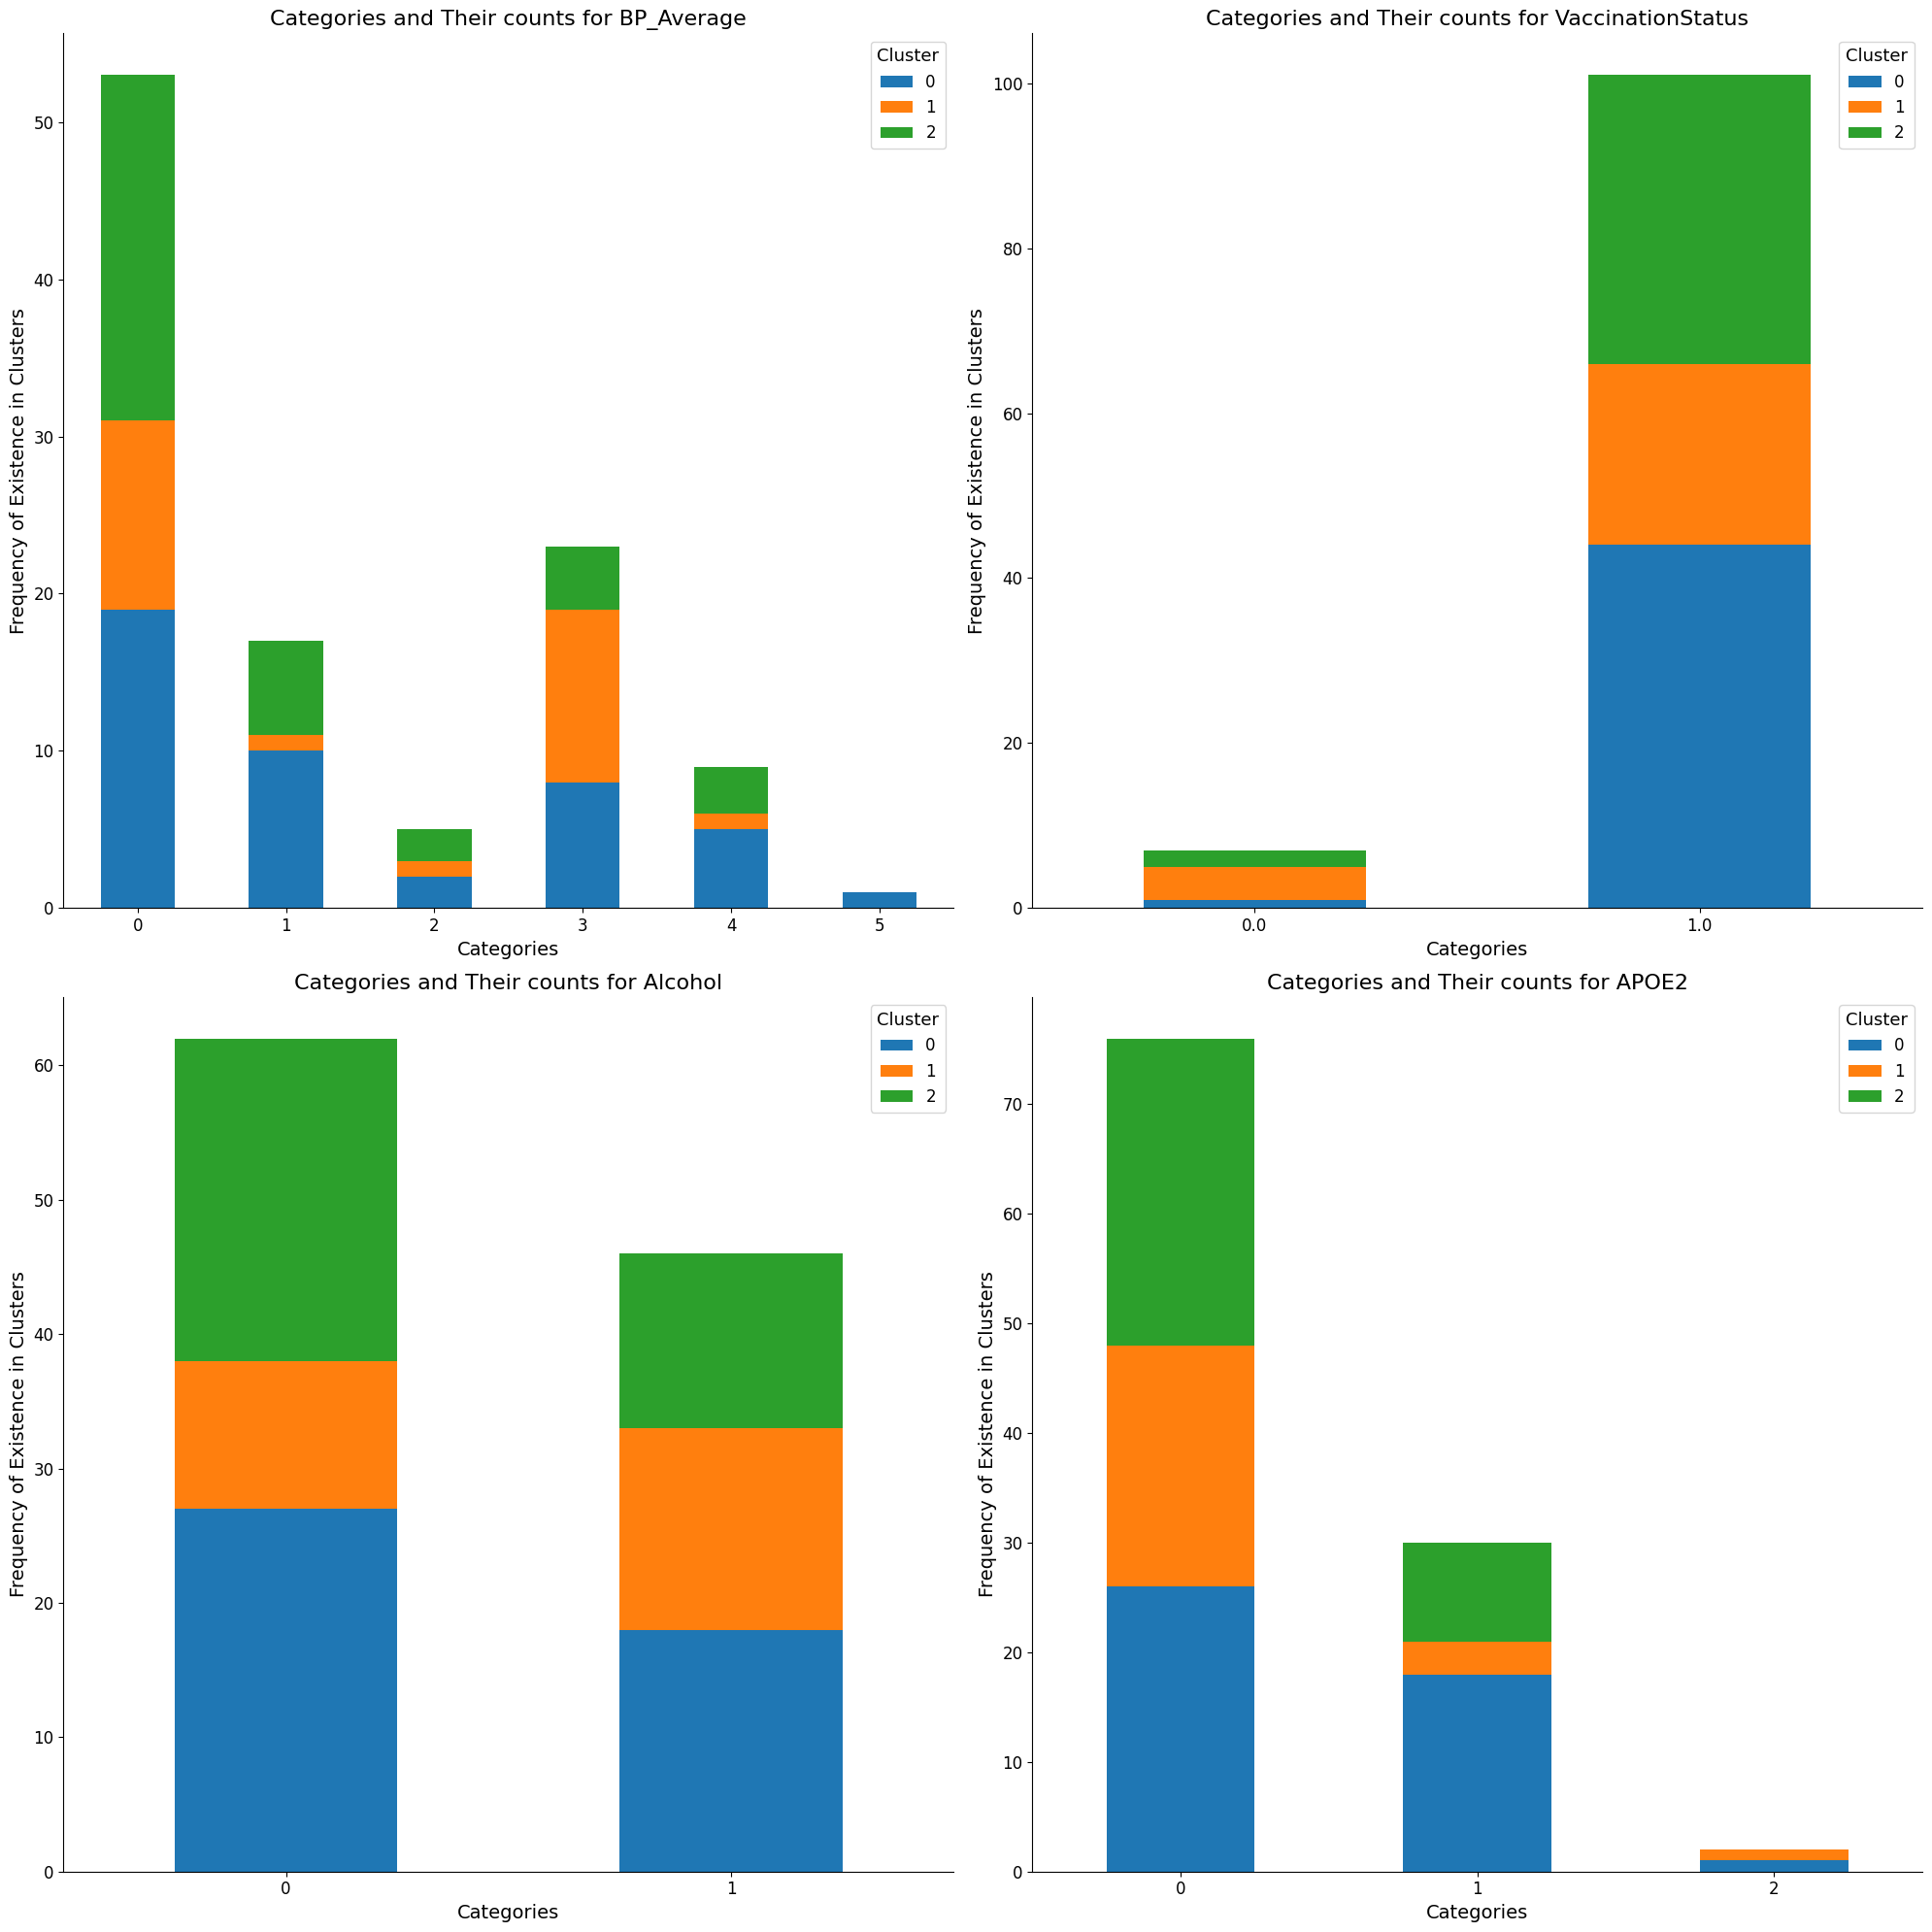

In [ ]:
categorical_features = ['BP_Average', 'VaccinationStatus', 'Alcohol', 'APOE2']

fig, axes = plt.subplots(2, 2, figsize=(20, 20))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    counts = df.groupby([feature, 'Cluster']).size().unstack(fill_value=0)

    # Plotting the stacked bar chart
    counts.plot(kind='bar', stacked=True, ax=axes[i])
    axes[i].set_title(f'Categories and Their counts for {feature}', fontsize=16)
    axes[i].set_xlabel('Categories', fontsize=14)
    axes[i].set_ylabel('Frequency of Existence in Clusters', fontsize=14)
    axes[i].legend(title='Cluster', title_fontsize='13', fontsize='12')
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].tick_params(axis='both', which='major', labelsize=12)
    plt.setp(axes[i].get_xticklabels(), rotation=0, ha='center')

plt.tight_layout()
plt.show()

# **Distribution of categorical values in clusters**

In [ ]:
for feature in ['BP_Average', 'Gender_x', 'Alcohol']:
    cross_tab = pd.crosstab(df['Cluster'], df[feature])
    print(f"\nDistribution of {feature} in clusters:")
    print(cross_tab)



Distribution of BP_Average in clusters:
BP_Average   0   1  2   3  4  5
Cluster                        
0           19  10  2   8  5  1
1           12   1  1  11  1  0
2           22   6  2   4  3  0

Distribution of Gender_x in clusters:
Gender_x   1   2
Cluster         
0         14  31
1          5  21
2         17  20

Distribution of Alcohol in clusters:
Alcohol   0   1
Cluster        
0        27  18
1        11  15
2        24  13


# **OBSERVATIONS**

**Observations on profiles of participants in each cluster and how they relate to breakthrough infections:**

Cluster 0:
- Largest cluster with 45 participants (39 Pfizer, 6 J&J)
- Highest rate of breakthrough infections (35.9%)
- Highest mean BMI, waist circumference, and weight
- Highest mean cholesterol and glucose levels
- Oldest average age
- Highest proportion of participants with high blood pressure (BP_Average categories 3-5)

Cluster 1:
- Smallest cluster with 26 participants (20 Pfizer, 6 J&J)
- Lowest rate of breakthrough infections (15.0%)
- Intermediate values for most health metrics
- Youngest average age
- Highest proportion of females (Gender_x category 2)

Cluster 2:
- 37 participants (22 Pfizer, 15 J&J)
- Intermediate rate of breakthrough infections (27.3%)
- Lowest mean BMI, waist circumference, and weight
- Lowest mean cholesterol and glucose levels
- Highest proportion of males (Gender_x category 1)
- Lowest proportion of alcohol consumers

These profiles suggest that Cluster 0, characterized by older age and poorer health metrics, is most susceptible to breakthrough infections. Cluster 1, with younger participants and intermediate health metrics, shows the lowest rate of breakthrough infections. Cluster 2, with the best health metrics but a higher proportion of J&J vaccinations, has an intermediate rate of breakthrough infections.

# **CONCLUSION**

**The analysis using explainable AI techniques reveals important insights for medical practitioners:**

1. Health status impact: Participants with higher BMI, larger waist circumference, elevated cholesterol and glucose levels, and older age (Cluster 0) are at higher risk for breakthrough infections. This emphasizes the importance of managing these health factors in vaccinated individuals.

2. Vaccine type consideration: While both Pfizer and J&J vaccines are represented in all clusters, the cluster with the highest proportion of J&J vaccines (Cluster 2) showed an intermediate rate of breakthrough infections despite having the best overall health metrics. This suggests potential differences in vaccine efficacy that warrant further investigation.

3. Age and gender factors: Younger age groups (Cluster 1) showed lower rates of breakthrough infections. Gender distribution varied across clusters, with the cluster having the highest proportion of females showing the lowest breakthrough infection rate.

4. Lifestyle factors: Alcohol consumption patterns differed across clusters, with the cluster showing the lowest alcohol consumption (Cluster 2) having an intermediate rate of breakthrough infections. This highlights the complex interplay of lifestyle factors with vaccine efficacy and infection risk.

5. Blood pressure correlation: The cluster with the highest proportion of participants with elevated blood pressure (Cluster 0) also had the highest rate of breakthrough infections, suggesting a potential link between hypertension and increased susceptibility.


**Benefits of using AI in this analysis:**

1. Pattern recognition: AI algorithms identified complex patterns in the data that might not be apparent through traditional statistical methods, revealing distinct clusters of participants with varying risk profiles.

2. Feature importance: The random forest classifier and SHAP analysis highlighted the most influential factors contributing to cluster formation and breakthrough infection risk, allowing medical practitioners to focus on key variables.

3. Multidimensional analysis: AI techniques enabled the simultaneous consideration of numerous variables, providing a more comprehensive understanding of the factors influencing breakthrough infections.

4. Data visualization: AI-powered visualizations (e.g., SHAP summary plots, cluster distribution charts) facilitate easier interpretation of complex relationships between variables.

5. Potential for personalized risk assessment: The clustering approach demonstrates the possibility of developing AI-driven tools for personalized risk assessment and targeted interventions for vaccinated individuals.

In conclusion, this explainable AI analysis provides valuable insights into the factors influencing breakthrough COVID-19 infections among vaccinated individuals. Medical practitioners should consider these findings when assessing patient risk, recommending booster shots, and designing preventive strategies. The study also demonstrates the potential of AI in enhancing our understanding of complex health issues and supporting evidence-based decision-making in clinical practice.
